# Initialisation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')

import ta

In [2]:
# Load the raw data
df_EURUSD = pd.read_csv('./FX Data/EURUSD1.csv', names=['Date','Time','Open','High','Low','Close','Volume'])

In [3]:
df_EURUSD.tail()

,Date,Time,Open,High,Low,Close,Volume
64995,2019.11.01,10:32,1.11610,1.11610,1.11600,1.11609,40
64996,2019.11.01,10:33,1.11607,1.11607,1.11557,1.11570,102
64997,2019.11.01,10:34,1.11570,1.11574,1.11550,1.11551,63
64998,2019.11.01,10:35,1.11550,1.11561,1.11550,1.11555,59
64999,2019.11.01,10:36,1.11557,1.11561,1.11550,1.11553,33


In [4]:
df_EURUSD['Timestamp'] = 0

In [5]:
for i in range(len(df_EURUSD)):
    df_EURUSD.at[i,'Timestamp']=i

In [6]:
# Add in technical indicators
df_ta=ta.add_all_ta_features(df_EURUSD, 'Open','High','Low','Close','Volume',fillna=True)

c:\users\seang\appdata\local\programs\python\python37\lib\site-packages\ta\trend.py:468: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
c:\users\seang\appdata\local\programs\python\python37\lib\site-packages\ta\trend.py:472: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [7]:
df_EURUSD.shape

(65000, 69)

In [8]:
df_EURUSD.head()

,Date,Time,Open,High,Low,Close,Volume,Timestamp,volume_adi,volume_obv,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
0,2019.08.15,15:22,1.11542,1.11547,1.11542,1.11544,20,0,-3.738490,20,...,99.757407,40.000000,40.000000,-60.000000,0.0,1.11544,0.0,1.118336,0.000000,0.000000
1,2019.08.15,15:23,1.11544,1.11567,1.11544,1.11564,54,1,35.913043,74,...,99.523674,88.000000,64.000000,-12.000000,0.0,1.11564,0.0,0.017930,0.017929,0.017930
2,2019.08.15,15:24,1.11564,1.11573,1.11563,1.11573,43,2,82.913043,117,...,99.527425,100.000000,76.000000,-0.000000,0.0,1.11573,0.0,0.008067,0.008067,0.025999
3,2019.08.15,15:25,1.11573,1.11579,1.11570,1.11579,41,3,84.000000,158,...,99.530752,100.000000,96.000000,-0.000000,0.0,1.11579,0.0,0.005378,0.005378,0.031378
4,2019.08.15,15:26,1.11579,1.11579,1.11569,1.11572,34,4,27.400000,124,...,98.991185,81.081081,93.693694,-18.918919,0.0,1.11572,0.0,-0.006274,-0.006274,0.025102


# Let's Plot Some Features! (detour)

### Bollinger Bands

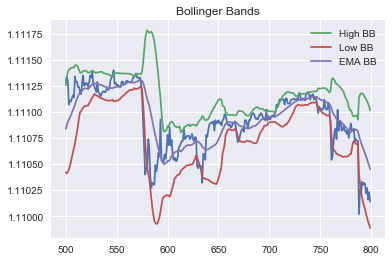

In [9]:
plt.plot(df_EURUSD[500:800].Close)
plt.plot(df_EURUSD[500:800].volatility_bbh, label='High BB')
plt.plot(df_EURUSD[500:800].volatility_bbl, label='Low BB')
plt.plot(df_EURUSD[500:800].volatility_bbm, label='EMA BB')
plt.title('Bollinger Bands')
plt.legend()
plt.show()

# Classifiers

Logistic, KNN, Random Forest Classifier.
Stack KNN, Random Forest, Naive Bayes together with with Logistic Regression as a meta-classifier?

#### Imports and Functions

In [60]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn import svm
from sklearn import metrics

In [49]:
#IMPORTANT
import warnings
warnings.filterwarnings("ignore")

In [44]:
def prepare_feature_matrix(start_ind, end_ind):
    df_temp=df_EURUSD[start_ind:end_ind]
    df_temp['delta']=0
    for i in range(start_ind, start_ind+len(df_temp)-1):
        if df_temp.loc[i+1,'Close'] > df_temp.loc[i,'Close']:
            df_temp.loc[i,'delta'] = 1
    X_temp = df_temp.drop(axis=1, labels=['Close','Timestamp','Date','Time','Open','High','Low','Volume','delta']).values
    y_temp=df_temp['delta'].to_frame().values
    return [X_temp,y_temp]

In [83]:
training_1 = prepare_feature_matrix(500,2000)

In [85]:
pred_1 = prepare_feature_matrix(2000,2500)

## All them models
#### Linear SVM

In [89]:
svm_model=svm.SVC()
svm_model.fit(training_1[0],training_1[1])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [90]:
svm_y_pred=svm_model.predict(pred_1[0])
print(metrics.accuracy_score(pred_1[1],svm_y_pred))

0.588


#### NuSVC

In [86]:
NuSVC_model=svm.NuSVC(gamma='auto')
NuSVC_model.fit(training_1[0],training_1[1])

NuSVC(cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False)

In [91]:
NuSVC_y_pred=NuSVC_model.predict(pred_1[0])
print(metrics.accuracy_score(pred_1[1],NuSVC_y_pred))

0.588


#### XGB

In [92]:
xgb_model=XGBClassifier()
xgb_model.fit(training_1[0],training_1[1])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [93]:
xgb_y_pred=xgb_model.predict(pred_1[0])
print(metrics.accuracy_score(pred_1[1],xgb_y_pred))

0.576


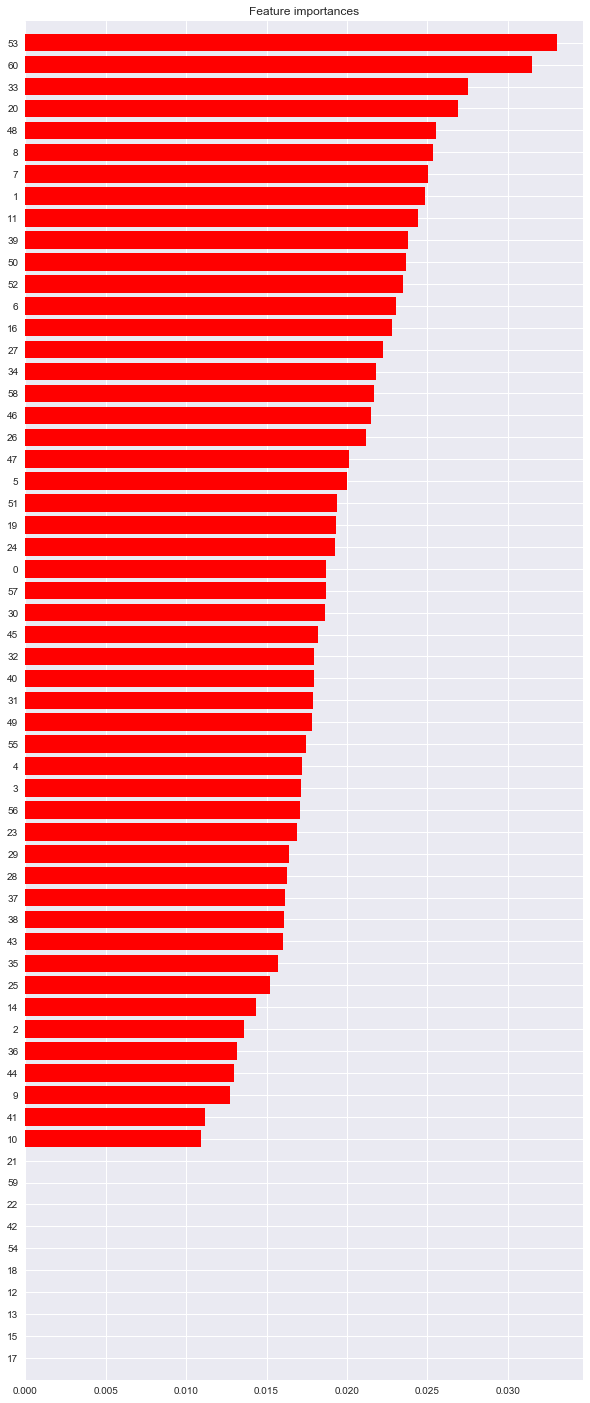

In [94]:
importances=xgb_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (10,25))
plt.title("Feature importances")
plt.barh(range(training_1[0].shape[1]), importances[indices], color="r", align="center")
plt.yticks(range(training_1[0].shape[1]), indices)
plt.ylim([-1, training_1[0].shape[1]])
plt.show()

# Random Stuff